In [1]:
import re
from gensim.models import FastText
from scipy import spatial
from nltk.tokenize import sent_tokenize
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import matplotlib.pyplot as plt
import csv
from post_parser_record import PostParserRecord

In [2]:

# This method takes in the trained model and the input sentence
# and returns the embedding of the sentence as the average embedding
# of its words
def get_sentence_embedding(model, sentence):

    words = sentence.split(" ")
    vector = 0
    for word in words:
        vector += model.wv[word]
    #print(vector/len(words))
    return vector/len(words)


def read_tsv_test_data(file_path):
  # Takes in the file path for test file and generate a dictionary
  # of question id as the key and the list of question ids similar to it
  # as value. It also returns the list of all question ids that have
  # at least one similar question
    dic_similar_questions = {}
    lst_all_test = []
    with open(file_path) as fd:
        rd = csv.reader(fd, delimiter="\t", quotechar='"')
        for row in rd:
            question_id = int(row[0])
            lst_similar = list(map(int, row[1:]))
            dic_similar_questions[question_id] = lst_similar
            lst_all_test.append(question_id)
            lst_all_test.extend(lst_similar)
    return dic_similar_questions, lst_all_test

<h3>FastText model</h3>  
We will use previously train FastText model to extract embeddings for posts.

In [3]:
# load model
ft_model = FastText.load("fastText.model")

In [4]:
# load data
duplicate_file = "duplicate_questions.tsv"
post_file = "Posts_law.xml"
dic_similar_questions, lst_all_test = read_tsv_test_data(duplicate_file)
post_reader = PostParserRecord(post_file)
dict_embeddings = {}

# get embeding for each question
for question_id in post_reader.map_questions:
    
    question = post_reader.map_questions[question_id]
    title = question.title
    body = question.body
    sentence = title + body
    sentence = re.sub(r"(?s)<.*?>", "", sentence)
    embedding = get_sentence_embedding(ft_model, sentence)
    dict_embeddings[question_id] = embedding

In [5]:
dict_embeddings

{1: array([ 0.04972092,  0.11370169, -0.46716157, -0.11429445,  0.29033294,
         0.20784378,  0.13508025,  0.11660731, -0.05868467, -0.04738393,
        -0.01809142,  0.15673932,  0.06326395,  0.15873347,  0.18723315,
         0.14848316, -0.01300483,  0.22345787,  0.06760728, -0.07448144,
         0.06868036, -0.14945582, -0.09920026, -0.20025297, -0.2246526 ,
        -0.13967624,  0.08370151,  0.05666821, -0.19455795,  0.30605286,
         0.16038343, -0.18464635,  0.07154179, -0.04486359,  0.04147887,
        -0.02991481,  0.19578466, -0.09718348,  0.23075971, -0.08775702,
        -0.002824  , -0.26388246, -0.2516037 ,  0.01182321,  0.16106519,
         0.10985287, -0.1076007 ,  0.00354158, -0.06002709,  0.05378155,
        -0.00145226, -0.05968953,  0.0826465 , -0.10897443,  0.03984244,
         0.06711271, -0.28102326,  0.09464316,  0.03515458,  0.07015853,
        -0.30279005,  0.0799867 ,  0.06008659, -0.04977163, -0.0609397 ,
         0.09784982, -0.0277227 , -0.04336591,  

<h2>Load and process data</h2>  
For data processing task we will create positive and negative samples. Positive samples are pairs of similar questions and  we already have them in .tsv file. Negative samples are paris of questions that aren't labeled as the same. We will create negative samples ourselves. Then we will combine negative and positive data to train our model. 

<h2>Get Positive Samples</h2>  

In [6]:
pairs = []
negative_pairs = []
i = 0

# get positive pairs
for key in dic_similar_questions:
    
    # positive
    for value in dic_similar_questions[key]:
        pairs.append((key,value))
    
    # negative
    # if test id is not in similars for this key
    if lst_all_test[i] not in dic_similar_questions[key] and lst_all_test[i] != key:
        # create pair
        negative_pairs.append((lst_all_test[i],key))
        if i == (len(lst_all_test)-1):
            i = 0
        else:
            i+=1
        

In [7]:
print(len(negative_pairs))
print(len(pairs))

280
289


In [8]:
# function to load the dataframe
#
# embedding_dict - a dict to be loaded
# df - target dataframe
# pairs - list of tupples pairs of embeddings
# label - y
def load_df(embedding_dict, df, pairs, label):
    for index, (a,b) in enumerate(pairs):
    
        first = dict_embeddings[a]
        second = dict_embeddings[b]
        df.loc[-1] = [ first, second, label]  # adding a row
        df.index = df.index + 1 

In [9]:
# construct pandas dataframe with pairs of positive and negative samples
df_positive = pd.DataFrame(columns = ['a', 'b', 'y'])
df_negative = pd.DataFrame(columns = ['a', 'b', 'y'])

load_df(dict_embeddings, df_positive, pairs, 1)
load_df(dict_embeddings, df_negative, negative_pairs, 0)
print(df_positive.shape)
print(df_negative.shape)

(289, 3)
(280, 3)


In [10]:
# Append dataframes
df = pd.concat([df_positive, df_negative],                     
                      ignore_index = True,
                      sort = False)
# Shuffle rows
df = df.sample(frac=1).reset_index(drop=True)

df.head()

,a,b,y
0,"[0.06325225, 0.126597, -0.51236796, -0.1426326...","[0.034686033, 0.159355, -0.46199724, -0.121329...",1
1,"[-0.14299557, 0.22081248, -0.5494224, -0.03679...","[-0.029920336, 0.19711581, -0.5739085, -0.1211...",1
2,"[-0.022700513, 0.115825735, -0.461064, -0.0949...","[-0.002308164, 0.15273872, -0.45101205, -0.086...",1
3,"[-0.0073478906, 0.14236146, -0.45227835, -0.17...","[0.062068995, 0.119098715, -0.4775736, -0.1311...",1
4,"[0.0872099, 0.0899896, -0.4210287, -0.11283702...","[-0.14124925, 0.21090674, -0.5202769, 0.005755...",0


In [11]:
# Get X and y
y = df['y']
X = pd.DataFrame(df.drop(['y'], axis=1))
print(X.shape)
print(y.shape)

(569, 2)
(569,)


In [12]:
# Split data
# 80 - 10 - 10
X_train, X_test, y_train, y_test = train_test_split(
        X, y,stratify=y, test_size=0.2)

X_test, X_val, y_test, y_val = train_test_split(
        X_test, y_test, stratify=y_test, test_size=0.5)

In [13]:
X_val.shape

(57, 2)

In [14]:
# Convert to PyTorch tensor
X_train = torch.Tensor(list(X_train.values)).permute(0, 1, 2)[:, :, -1]
y_train = torch.tensor(y_train.values.astype(np.float32))
X_test = torch.Tensor(list(X_test.values)).permute(0, 1, 2)[:, :, -1]
y_test = torch.tensor(y_test.values.astype(np.float32))
X_val = torch.Tensor(list(X_val.values)).permute(0, 1, 2)[:, :, -1]
y_val = torch.tensor(y_val.values.astype(np.float32))

In [15]:
y_train[1]

tensor(1.)

In [16]:
from torch.nn.functional import normalize
X_train = normalize(X_train, dim=1)
X_val = normalize(X_val, dim=1)
X_test = normalize(X_test, dim=1)

<h2>Binary Classification</h2>  
For binary classification we use Binary Cross Entropy Loss, Adam optimizer and a scheduler to revive session when necessary. 

In [152]:
import torch.nn as nn
    
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(2, 90)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(90, 60)
        self.relu2 = nn.ReLU()       
        self.layer3 = nn.Linear(60, 20)
        self.relu3 = nn.ReLU()     
        self.layer4 = nn.Linear(20, 10)
        self.relu4 = nn.ReLU() 
        self.output = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.relu2(self.layer2(x))
        x = self.relu3(self.layer3(x))
        x = self.relu4(self.layer4(x))
        x = self.output(x)
        return torch.sigmoid(x)

In [173]:
class ModelModule():

    model = Model()
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    epochs = 40
    
    # Calculates and returns accuracy. Called after forward step.
    #
    # y_true - traget labels
    # y_pred - predicted labels
    def calculate_accuracy(self, y_true, y_pred):
        y_pred = torch.round(y_pred)
        correct = torch.sum((y_true == y_pred).float())
        acc = (correct.sum().item() / len(y_pred))
        return acc

    # Train model
    #
    # model - model 
    # X_train - training tensor
    # y_train - training labels
    # X_val - validation tensor
    # y_val - validation labels
    def train(self, X_train, y_train, X_val, y_val):
        batch_size = 40
        # get mini batches
        X_mini_batches = torch.split(X_train, batch_size)
        y_mini_batches = torch.split(y_train, batch_size)

        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []
        best_epoch = 0
        best_accuracy = 0
        # train
        for epoch in range(self.epochs):

            epoch_loss = 0
            epoch_accuracy = 0
            val_loss = 0
            val_accuracy = 0
            self.model.train()
            for x_mini, y_mini in zip(X_mini_batches, y_mini_batches):
            
                # refresh gradients
                self.optimizer.zero_grad()
                 # forward pass
                train_prediction = self.model.forward(x_mini.float())

                # calculate loss
                train_prediction = torch.squeeze(train_prediction)  
                train_loss = self.loss_fn(train_prediction, y_mini)

                # calculate accuracy
                epoch_accuracy = epoch_accuracy + self.calculate_accuracy(y_mini, train_prediction.unsqueeze(1)) 
 
                # Get gradients
                train_loss.backward()
                # update parameters
                self.optimizer.step()

                # accumulate loss
                epoch_loss = epoch_loss + train_loss.item()

            
            # refresh gradients
            self.optimizer.zero_grad()
            # validation
            val_pred = self.model.forward(X_val.float())
            val_pred = torch.squeeze(val_pred)

            #calculate loss
            val_loss = self.loss_fn(val_pred, y_val)
            validation_loss = val_loss.item()

            #scheduler.step(val_loss)
            # calculate accuracy
            val_accuracy = self.calculate_accuracy(y_val, val_pred.unsqueeze(1))

            if val_accuracy > best_accuracy:
                torch.save(self.model.state_dict(), 'best_model.pth')
                best_accuracy = val_accuracy
                best_epoch = epoch

            # generate train val loss plot
            epoch_loss = epoch_loss / len(X_mini_batches)
            epoch_accuracy =  epoch_accuracy / len(X_mini_batches)
            val_losses.append(validation_loss)
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_accuracy)
            val_accuracies.append(val_accuracy)

            print('Epoch ', epoch, '/', self.epochs)
            print(f"Train Loss: {epoch_loss:.5f},Validation Loss: {validation_loss:.5f}, Train Accuracy: {epoch_accuracy:.5f},Validation Accuracy: {val_accuracy:.5f}")
        print("model saved at epoch ", best_epoch)    
        return train_losses, val_losses, train_accuracies, val_accuracies 
    
        
    def evaluate(self, X, y):

        with torch.no_grad():
            predictions = self.model.forward(X.float())
            predictions = torch.squeeze(predictions)
            loss = self.loss_fn(predictions, y)
            accuracy = self.calculate_accuracy(y, predictions)
            
        
        return loss.item(), accuracy, predictions

In [174]:
module = ModelModule()
train_losses, val_losses, train_accuracies, val_accuracies = module.train(X_train, y_train, X_val, y_val)

Epoch  0 / 40
Train Loss: 0.69662,Validation Loss: 0.69526, Train Accuracy: 19.25000,Validation Accuracy: 29.00000
Epoch  1 / 40
Train Loss: 0.69642,Validation Loss: 0.69517, Train Accuracy: 19.25000,Validation Accuracy: 29.00000
Epoch  2 / 40
Train Loss: 0.69626,Validation Loss: 0.69509, Train Accuracy: 19.25000,Validation Accuracy: 29.00000
Epoch  3 / 40
Train Loss: 0.69612,Validation Loss: 0.69501, Train Accuracy: 19.25000,Validation Accuracy: 29.00000
Epoch  4 / 40
Train Loss: 0.69598,Validation Loss: 0.69495, Train Accuracy: 19.25000,Validation Accuracy: 29.00000
Epoch  5 / 40
Train Loss: 0.69589,Validation Loss: 0.69491, Train Accuracy: 19.25000,Validation Accuracy: 29.00000
Epoch  6 / 40
Train Loss: 0.69583,Validation Loss: 0.69489, Train Accuracy: 19.25000,Validation Accuracy: 29.00000
Epoch  7 / 40
Train Loss: 0.69579,Validation Loss: 0.69486, Train Accuracy: 19.25000,Validation Accuracy: 29.00000
Epoch  8 / 40
Train Loss: 0.69574,Validation Loss: 0.69484, Train Accuracy: 19.2

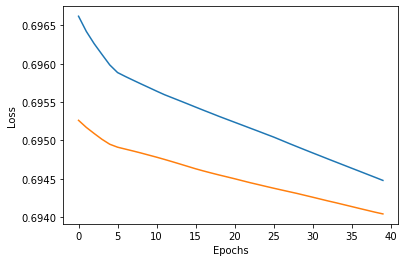

In [175]:
import itertools
epochs_ = list(itertools.chain(range(1, 50+1)))

zipped = list(zip(train_losses, val_losses))
df = pd.DataFrame(zipped, columns=['Train Loss', 'Validation Loss'])



plt.plot(df['Train Loss'])
plt.plot(df['Validation Loss'])

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [176]:
#evaluate on the test set
# load the saved best model
mod = module.model.load_state_dict(torch.load('best_model.pth'))

# evaluate on test set
test_loss, test_accuracy, predictions = module.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss:.5f}, Test Accuracy: {test_accuracy:.5f}")

Test Loss: 0.69546, Test Accuracy: 0.50877


<h3>Average P@1</h3>

In [177]:
preds = torch.round(predictions)
correct = sum(torch.logical_and(preds, y_test))
p_at_1 = correct.item()/len(y_test)
p_at_1

0.5087719298245614

<h3>Confusion Matrix</h3>

In [178]:
confusion_vector = preds / y_test

true_positives = torch.sum(confusion_vector == 1).item()
false_positives = torch.sum(confusion_vector == float('inf')).item()
true_negatives = torch.sum(torch.isnan(confusion_vector)).item()
false_negatives = torch.sum(confusion_vector == 0).item()

In [179]:
print('True positives ', true_positives)
print('True negatives ', true_negatives)
print('False positives ', false_positives)
print('False negatives ', false_negatives)

True positives  29
True negatives  0
False positives  28
False negatives  0
